In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid


sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})

<Figure size 432x288 with 0 Axes>

In [2]:
save_plots = False

## Load Data

In [3]:
normalization = 'min_max_normalization' # 'standardization'

In [4]:
###
#  construct a single dictionary from those of all the runs
###
def get_bo_res(which_results: str, nb_run: int, norm_type):
    assert "results" in which_results
    # initialize dict to store results 
    bo_res = pickle.load(open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, which_results, which_results, 0), 'rb'))
    for key in bo_res.keys():
        bo_res[key] = []
        
    # iterate though the runs
    for n in range(nb_run):
        # get results dict for specified run
        bo_res_file = pickle.load(
                        open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, which_results, which_results, n), 'rb'))
        
        # append results to end of list
        for key in bo_res_file.keys():
            key_res = bo_res_file[key]
            bo_res[key].append(key_res)
            
    return bo_res

In [5]:
###
#  features and molecular simulation data
###
if normalization == 'min_max_normalization':
    file = h5py.File("targets_and_normalized_features.jld2", "r")
else:
    file = h5py.File("targets_and_standardized_features.jld2", "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) # ... Needs to be tensor?
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  bayesian optimization data
###
# COF IDs used for initialization
init_cof_ids_file = pickle.load(open('search_results/{}/initializing_cof_ids.pkl'.format(normalization), 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']

nb_COFs_initialization = len(init_cof_ids[0])
nb_runs = len(init_cof_ids)

# random search 
random_search_res = pickle.load(open('search_results/{}/random_search_results.pkl'.format(normalization), 'rb'))

# multi-fidelity search
mfbo_res = get_bo_res('mfbo_results', nb_runs, normalization)

# single-fideliy search
sfbo_res = get_bo_res('sfbo_results', nb_runs, normalization)

# number of iterations per run
nb_iters = len(mfbo_res['acquired_set'][0])

###
#  quick checks
###
# structure of data
assert len(sfbo_res['ids_acquired'][0]) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_iters
assert sfbo_res['nb_COFs_initialization'][0] == nb_COFs_initialization

# each run has the correct initializing COFs
assert all([
       all(sfbo_res['ids_acquired'][r][:nb_COFs_initialization] == init_cof_ids[r]) for r in range(nb_runs)])

In [6]:
# the max number of iterations needed for any of the runs
max_SFBO_iters = max(sfbo_res['BO_iter_top_cof_acquired'])
max_MFBO_iters = max(mfbo_res['BO_iter_top_cof_acquired'])

# the highest accumulated cost up to the max number of iterations needed
max_SFBO_cost = np.max(sfbo_res['accumulated_cost'][:][:max_SFBO_iters+1])
max_MFBO_cost = np.max(mfbo_res['accumulated_cost'][:][:max_MFBO_iters+1])


print("The max number of iterations needed for any of the runs -")
print("\tSFBO: {}".format(max_SFBO_iters))
print("\tMFBO: {}".format(max_MFBO_iters))
print("The highest accumulated cost up to the max number of iterations needed -")
print("\tSFBO: {} [hr]".format(max_SFBO_cost))
print("\tMFBO: {} [hr]".format(max_MFBO_cost))

The max number of iterations needed for any of the runs -
	SFBO: 53
	MFBO: 110
The highest accumulated cost up to the max number of iterations needed -
	SFBO: 762.9641438672282 [hr]
	MFBO: 281.682888385256 [hr]


## Search Efficientcy Curves

### Helper functions

In [7]:
def get_distribution(res, maxes=False):
    # initialize arrays for dist.
    mu      = np.zeros(nb_iters)
    sig_bot = np.zeros(nb_iters)
    sig_top = np.zeros(nb_iters)
    
    ###
    #  look at all runs and get the dist.
    ###
    for i in range(1, nb_iters+1):
        if maxes:
            # max value acquired up to this point (over all runs)       
            vals_at_iter = np.array([max(res[r][:i]) for r in range(nb_runs)])
        else:
            # make an arrey of all the values at a given iteration
            vals_at_iter = np.array([res[r][i-1] for r in range(nb_runs)])
        assert np.size(vals_at_iter) == nb_runs
        mu[i-1]      = np.mean(vals_at_iter)
        sig_bot[i-1] = np.std(vals_at_iter[vals_at_iter < mu[i-1]])
        sig_top[i-1] = np.std(vals_at_iter[vals_at_iter > mu[i-1]])
        
    return  mu, sig_bot, sig_top

# Plots

In [8]:
###
#  when, on average, is the top COF located? 
###
mfbo_mean_iter_top_cof = int(np.round(np.mean(mfbo_res['BO_iter_top_cof_acquired'])))
sfbo_mean_iter_top_cof = int(np.round(np.mean(sfbo_res['BO_iter_top_cof_acquired'])))

print("Average iterations to locate top COF - ")
print("MFBO:\t", mfbo_mean_iter_top_cof)
print("SFBO:\t", sfbo_mean_iter_top_cof)

Average iterations to locate top COF - 
MFBO:	 49
SFBO:	 34


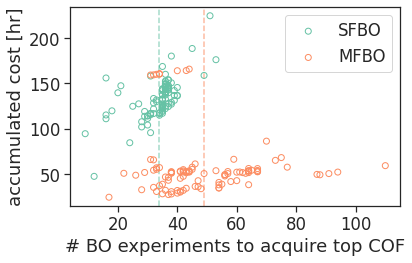

In [9]:
a = [mfbo_res['accumulated_cost'][r][mfbo_res['BO_iter_top_cof_acquired'][r]] for r in range(nb_runs)]
b = [sfbo_res['accumulated_cost'][r][sfbo_res['BO_iter_top_cof_acquired'][r]] for r in range(nb_runs)]

plt.figure()
plt.scatter(sfbo_res['BO_iter_top_cof_acquired'], b, ec="C0", fc='none', label="SFBO", zorder=100)
plt.scatter(mfbo_res['BO_iter_top_cof_acquired'], a, ec="C1", fc='none', label="MFBO", zorder=100)

# plt.bar()

plt.axvline(x=sfbo_mean_iter_top_cof, color="C0", linestyle="--", lw=1.5, alpha=0.6)
plt.axvline(x=mfbo_mean_iter_top_cof, color="C1", linestyle="--", lw=1.5, alpha=0.6)


plt.legend()
plt.xlabel('# BO experiments to acquire top COF')
plt.ylabel('accumulated cost [hr]')

plt.tight_layout()
if save_plots:
    plt.savefig("./figs/BO_experiments_vs_acc_cost.pdf", dpi=600, format='pdf')
plt.show()

SFBO  max search time =  224.64728720691468
MFBO  max search time =  165.81920040382286


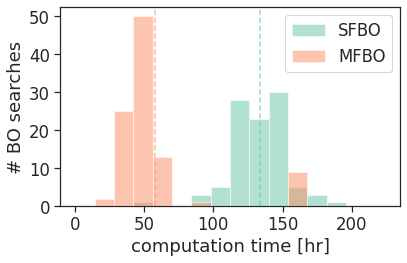

In [10]:
###
#  make a histogram of the distribution of accumulated cost 
###
fig = plt.figure()
width = 14
bins = np.array([int(width*i) for i in range(int(250 / width))])

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    x = []
    # color
    color = "C{}".format(i)
    
    for r in range(nb_runs):
        n = res['BO_iter_top_cof_acquired'][r]
        x.append(res['accumulated_cost'][r][n])
    
    print(search_type, " max search time = ", np.max(x))
    plt.axvline(x=np.mean(x), color=color, linestyle="--", lw=1.5, alpha=0.6)
    plt.hist(x, bins, label=search_type, color=color, alpha=0.5, zorder=10)


plt.xlabel('computation time [hr]')
plt.ylabel('# BO searches')
plt.legend()
plt.tight_layout()
if save_plots:
    plt.savefig("./figs/hist_accumulated_cost_destribution.pdf", format="pdf")
plt.show()

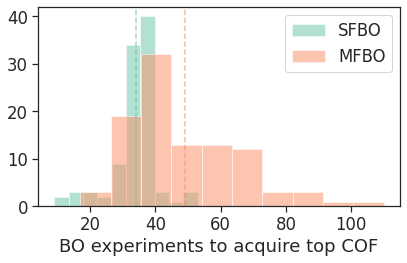

In [11]:
fig = plt.figure()
# width = 3
# bins = np.array([int(width*i) for i in range(int(nb_iters / width))])

plt.hist(np.array(sfbo_res['BO_iter_top_cof_acquired']), 
         label='SFBO', color="C0", alpha=0.5)

plt.axvline(x=sfbo_mean_iter_top_cof, color="C0", linestyle="--", lw=1.5, alpha=0.6)

plt.hist(np.array(mfbo_res['BO_iter_top_cof_acquired']), 
         label='MFBO', color="C1", alpha=0.5)

plt.axvline(x=mfbo_mean_iter_top_cof, color="C1", linestyle="--", lw=1.5, alpha=0.6)


plt.xlabel('BO experiments to acquire top COF')
plt.ylabel('# runs')
plt.ylabel('')
plt.legend()
plt.tight_layout()
if save_plots:
    plt.savefig("./figs/hist_BO_iter_top_cof_acquired.pdf", format="pdf")
plt.show()

SFBO
2
53
MFBO
5
110


/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ng/.local/lib/python3.8/site-packages/numpy/core/_methods.p

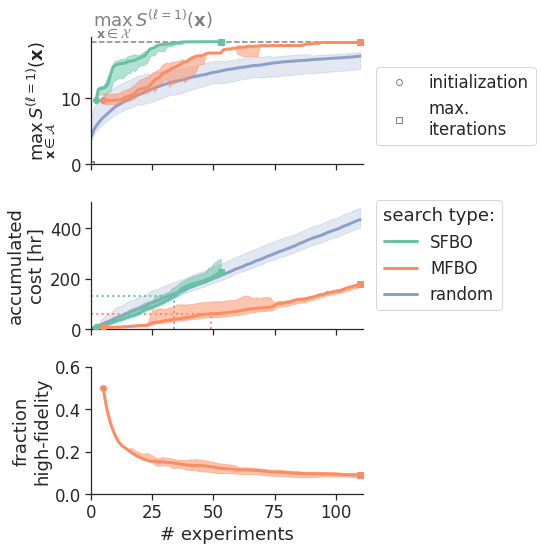

In [12]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))  
markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = np.max(res['BO_iter_top_cof_acquired'])
    print(iter_top_cof_acquired)
    
    mean_iter_top_cof = int(np.round(np.mean(res['BO_iter_top_cof_acquired'])))

    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  get distributions 
    ###
    # y_maxes
    y_max_mu, y_max_sig_bot, y_max_sig_top = get_distribution(res['y_max_acquired'], maxes=True)
    # accumulated_cost
    acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(res['accumulated_cost'])
    
    ###
    #  accumulated cost
    ###
    ax[1].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               acc_cost_mu[iter_start:iter_top_cof_acquired+1], 
               label=search_type, 
               color=color, zorder=10)
    ax[1].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                       acc_cost_mu[iter_start:iter_top_cof_acquired+1] - 
                                   acc_cost_sig_bot[iter_start:iter_top_cof_acquired+1],
                       acc_cost_mu[iter_start:iter_top_cof_acquired+1] + 
                                   acc_cost_sig_top[iter_start:iter_top_cof_acquired+1],
                       alpha=0.5, color=color, zorder=5)
    # average cost of search
    acc_ymax = acc_cost_mu[mean_iter_top_cof] / 450 # normed to max
    acc_xmax = mean_iter_top_cof / np.max(mfbo_res['BO_iter_top_cof_acquired'])
    
    ax[1].axvline(x=[mean_iter_top_cof], ymax=acc_ymax, 
                  color=color, lw=2, linestyle=":")
    ax[1].axhline(y=[acc_cost_mu[mean_iter_top_cof]], xmax=acc_xmax, 
                  color=color, lw=2, linestyle=":")
    # start and stop
    ax[1].scatter([iter_start], [acc_cost_mu[iter_start]], color=color, marker="o", zorder=100)
    ax[1].scatter([iter_top_cof_acquired], [acc_cost_mu[iter_top_cof_acquired]], 
                  color=color, marker="s", zorder=100)
    
    ###
    #  search efficiency curves
    ###    
    ax[0].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               y_max_mu[iter_start:iter_top_cof_acquired+1], 
               color=color, linestyle="-", zorder=10)
    ax[0].fill_between(iter_range[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] - 
                                       y_max_sig_bot[iter_start:iter_top_cof_acquired+1], 
                   y_max_mu[iter_start:iter_top_cof_acquired+1] + 
                                       y_max_sig_top[iter_start:iter_top_cof_acquired+1],
                   alpha=0.5, color=color, zorder=5)
    # start and stop
    ax[0].scatter([iter_start], [y_max_mu[iter_start]], 
                  label='initialization',
                  color=color, marker="o")
    ax[0].scatter([iter_top_cof_acquired], y_max_mu[iter_top_cof_acquired+1], 
                  label='square', 
                  color=color, marker="s", zorder=100)
    
    ###
    #  fidelity fraction 
    ### 
    if search_type == "MFBO":
        # get dist.
        fid_frac_mu, fid_frac_sig_bot, fid_frac_sig_top = get_distribution(res['fidelity_fraction'])
        # plot
        ax[2].plot(iter_range[iter_start:iter_top_cof_acquired+1],
                   fid_frac_mu[iter_start:iter_top_cof_acquired+1], 
                   color=color)
        ax[2].fill_between(iter_range[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] - 
                                   fid_frac_sig_bot[iter_start:iter_top_cof_acquired+1],
                           fid_frac_mu[iter_start:iter_top_cof_acquired+1] + 
                                   fid_frac_sig_top[iter_start:iter_top_cof_acquired+1], 
                           alpha=0.5, color=color)
        # start and stop
        ax[2].scatter([iter_start], [fid_frac_mu[iter_start]], 
                      label='initialization',
                      color=color, marker="o")
        ax[2].scatter([iter_top_cof_acquired], fid_frac_mu[iter_top_cof_acquired+1], 
                      label='square', 
                      color=color, marker="s", zorder=100)

###
#  random search (SFBO, l=1)
###
iter_stop = np.max(mfbo_res['BO_iter_top_cof_acquired']) + 1
# y_maxes
ax[0].plot(range(iter_stop), random_search_res['y_rs_max_mu'][:iter_stop], 
           color="C2", zorder=2)

ax[0].fill_between(range(iter_stop), 
                   random_search_res['y_rs_max_mu'][:iter_stop] - 
                   random_search_res['y_rs_max_sig_bot'][:iter_stop], 
                   random_search_res['y_rs_max_mu'][:iter_stop] + 
                   random_search_res['y_rs_max_sig_top'][:iter_stop], 
                   alpha=0.25, color="C2", zorder=1)
# accumulated cost
acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])
ax[1].plot(range(iter_stop), acc_cost_mu[:iter_stop], 
           label="random", color="C2", zorder=2)

ax[1].fill_between(range(iter_stop), 
                   acc_cost_mu[:iter_stop] - acc_cost_sig_bot[:iter_stop], 
                   acc_cost_mu[:iter_stop] + acc_cost_sig_top[:iter_stop], 
                   alpha=0.25, color="C2", zorder=1)

###  
#  global maximum
###
ax[0].axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
ax[0].text(1.0, max(y[1]) + 2.5, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, S^{(\ell=1)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
# search efficiency 
ax[0].set_xlim(xmin=0, xmax=iter_stop)
ax[0].set_ylim(ymin=0)
ax[0].set_ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, S^{(\ell=1)}(\mathbf{x})$')
# dummy plots for legend
p_empty_cir = ax[0].plot([0], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = ax[0].plot([0], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='max.\niterations')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend([handles[0], handles[1]], [labels[0], labels[1]], loc=(1.05, 0.15))

# accumulated cost
ax[1].set_ylim(ymin=0)
ax[1].set_ylabel("accumulated\ncost [hr]")
ax[1].legend(title="search type:", loc=(1.05, 0.15))

# fidelity fraction
ax[2].set_ylim([0, 0.6])
ax[2].set_xlabel("# experiments")
ax[2].set_ylabel("fraction\nhigh-fidelity")

plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/SearchEfficiency_AccCost_FidFrac_distributions.pdf", format="pdf")
plt.show()

## Pirinciple Component Analysis

In [13]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

###
#  test point
###
a = torch.from_numpy(np.array([X[:, i].mean() for i in range(X.size()[1])]))
X_center = pca.transform(a.reshape(1, -1))

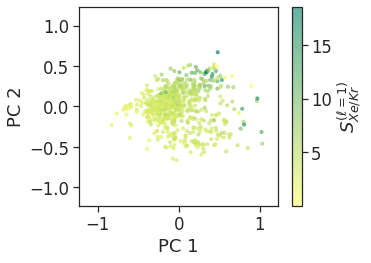

In [14]:
cmap_name = cm.summer_r # sequential colormap (reversed)

###
#  low dimensional (PCA) visualization of the entire dataset
###
fig = plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

###
#  axis commands
###
ax_lim = max([np.max(X_2D), abs(np.min(X_2D))]) + 0.2
plt.xlim([-ax_lim, ax_lim])
plt.ylim([-ax_lim, ax_lim])

plt.xticks()
plt.yticks()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")

plt.gca().set_aspect('equal', 'box')

plt.tight_layout()
# if save_plots:
#     plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", dpi=600, format="pdf")
plt.show()

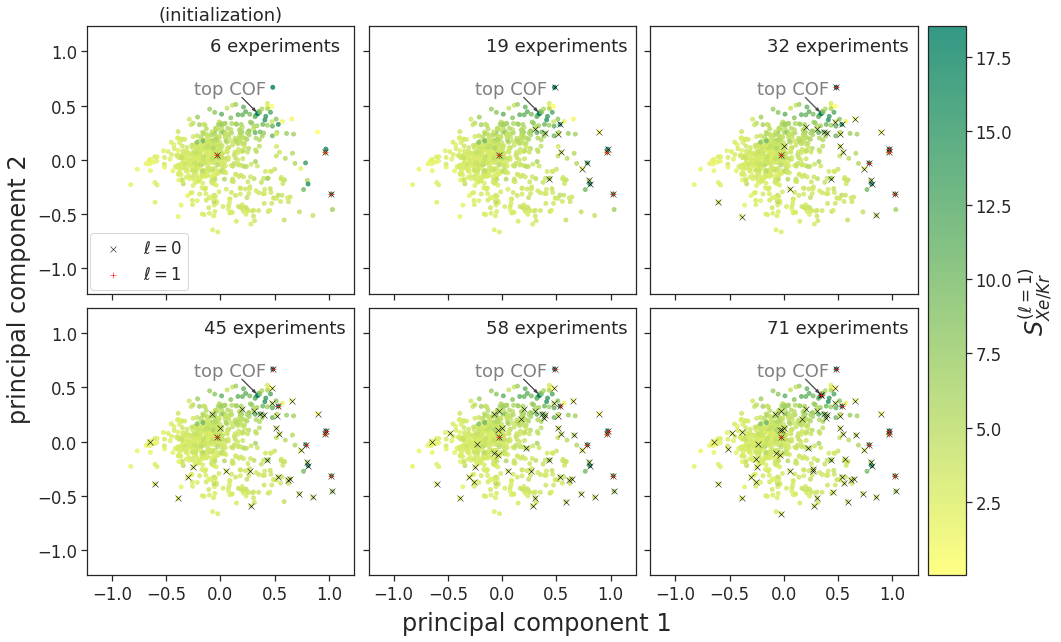

In [15]:
nb_acquired = [2*nb_COFs_initialization + i*13 for i in range(6)]

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8*2 + 0.5])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2, 3),
                 axes_pad=0.2,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][0][:nb]
    lf_acq = acq[acq[:, 0] == 0, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == 1, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)
    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=15, alpha=0.8) 
    
    ### 
    # plot center of feature space and transformed point
    ###
#     if i == 0:
#         ax.scatter(X_center[:, 0], X_center[:, 1], color="b", marker="*", s=30)

    ###
    #  indicate top COF
    #  arrow is drawn from (x, y) to (x+dx, y+dy)
    ###
    top_cof_id = np.argmax(y[1])
    eps = 0.15
    ax.arrow(X_2D[top_cof_id, 0]-eps, X_2D[top_cof_id, 1]+eps, eps*0.7, -eps*0.7,
             head_width=0.025, color='k', alpha=0.6)
    ax.text(X_2D[top_cof_id, 0]-3.95*eps, X_2D[top_cof_id, 1]+1.2*eps, 'top COF', color="grey")

    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1], 0], X_2D[lf_acq[:nb, 1], 1], 
                  label="$\ell=0$",
                  color='k', marker='x', s=35, lw=0.5) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1], 0], X_2D[hf_acq[:nb, 1], 1], 
               label="$\ell=1$",
               color='r', marker='+', s=35, lw=0.5, zorder=1)
    

    
    # subplot titles --- use ax.text 
    if i == 0:
        ax.set_title('(initialization)')
    ax.text(0.5, 1.0, '{} experiments'.format(nb_acquired[i]), ha='center')
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$", fontsize=24)

###
#  axis commands
###
grid[0].legend(loc=(0.013, 0.013))
fig.text(0.155, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
fig.text(0.52, 0.05, 'principal component 1', ha='center', fontsize=24)

grid[0].set_xlim([-ax_lim, ax_lim])
grid[0].set_ylim([-ax_lim, ax_lim])


if save_plots:
    plt.savefig("./figs/MFBO_PCA_dynamics.pdf", bbox_inches="tight", dpi=600, format="pdf")
plt.show()

# Radar Plot of Feature Vector

custom scale on each axis [here](https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart)

In [16]:
###
#  load data
###
cof_file = h5py.File("top_COF_feature_vector.jld2", "r")
values = np.array(cof_file['features']).tolist()
print("Top COF ID = ", top_cof_id)
print("Top COF feature vector:\n", values)

# descriptors
property_type = ['geometric', 'chemical']
descriptors = []

for prop in property_type:
    filename = "descriptors/{}_properties.csv".format(prop)
    df = pd.read_csv(filename)
    for descroptor in df.columns:
        if descroptor != "crystal_name": 
            descriptors.append(descroptor)
            
###
#  fix labels for plotting
###
pretty_des_names = dict({'pore_diameter_Å': 'pore diameter [Å]\n\n', 
                         'void_fraction': 'void fraction\n',
                         'surface_area_m²g⁻¹': 'surface area [m² g⁻¹]\n',
                         'crystal_density': 'crystal density [kg m⁻³]\n'
                        })

for n, des in enumerate(descriptors):
    if des in pretty_des_names.keys():
        descriptors[n] = pretty_des_names[des] + '\n'
    else:
        descriptors[n] = descriptors[n] + "  "
        
print("feature labels: \n", descriptors)

Top COF ID =  375
Top COF feature vector:
 [5.74091, 0.33218, 4502.94, 1071.1983709342826, 0.0, 0.0, 0.5369127516778524, 0.348993288590604, 0.0, 0.10738255033557047, 0.0, 0.0, 0.0, 0.006711409395973154]
feature labels: 
 ['pore diameter [Å]\n\n\n', 'void fraction\n\n', 'surface area [m² g⁻¹]\n\n', 'crystal density [kg m⁻³]\n\n', 'B  ', 'O  ', 'C  ', 'H  ', 'Si  ', 'N  ', 'S  ', 'P  ', 'halogens  ', 'metals  ']


In [17]:
tuple(descriptors)

('pore diameter [Å]\n\n\n',
 'void fraction\n\n',
 'surface area [m² g⁻¹]\n\n',
 'crystal density [kg m⁻³]\n\n',
 'B  ',
 'O  ',
 'C  ',
 'H  ',
 'Si  ',
 'N  ',
 'S  ',
 'P  ',
 'halogens  ',
 'metals  ')

In [18]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=3):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1, 0.1, 0.9, 0.9], polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, labels=variables)
        [txt.set_rotation(angle-90) for txt, angle in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
#             ax.set_theta_direction(-1)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            gridlabel = ["{0:.2f}".format(round(x, 2)) for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        # Go through labels and adjust alignment based on where
        # it is in the circle.
        for label, angle in zip(self.ax.get_xticklabels(), self.angle):
#             if angle == 0:
#                 label.set_horizontalalignment('left')
            if np.pi/2 < angle <= 3*np.pi/2:
                label.set_horizontalalignment('center')
            else:
                label.set_horizontalalignment('left')
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

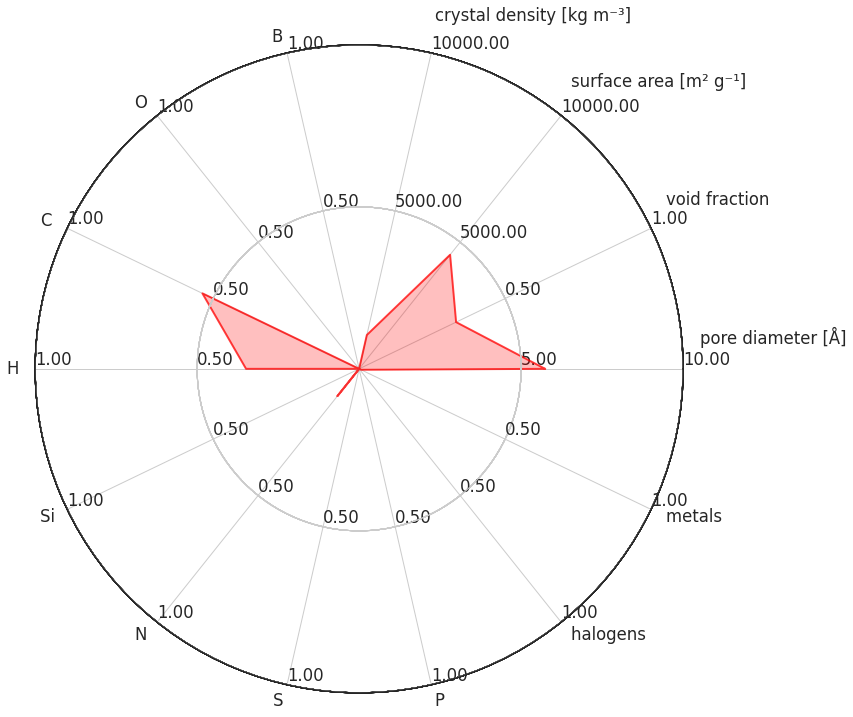

In [19]:
###
#  example data
###
# variables = ("Normal Scale", "Inverted Scale", "Inverted 2", 
#             "Normal Scale 2", "Normal 3", "Normal 4 %", "Inverted 3 %")
variables = tuple(descriptors)

# data = (1.76, 1.1, 1.2, 4.4, 3.4, 86.8, 20)
data = tuple(values)

# ranges = [(0.0, 10), (0.0, 1.3), (0.0, 0.5), (0.0, 4.5), (0.0, 3.7), (0.0, 87), (0.0, 10)] # (y1, y2)   
# ymax will be 10**(base) 
limits = []
for val in values:
    if 0 <= val <= 1:
        base = 0
    else:
        base = int(np.ceil(np.log10(val)))
    limits.append((0, 10**base))
    
ranges = limits

###
#  plotting
###
fig1 = plt.figure(figsize=(10, 10))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data, color='red', alpha=0.7, lw=2, zorder=100)
radar.fill(data, color='red', alpha=0.25)

if save_plots:
    plt.savefig("./figs/radar_with_diff_axes.pdf", bbox_inches="tight", dpi=600, format='pdf')

plt.show()  

In [20]:
# ###
# #  load data
# ###
# cof_file = h5py.File("top_COF_feature_vector.jld2", "r")
# values = np.array(cof_file['features']).tolist()
# print("Top COF ID = ", top_cof_id)
# print("Top COF feature vector:\n", values)

# # descriptors
# property_type = ['geometric', 'chemical']
# descriptors = []

# for prop in property_type:
#     filename = "descriptors/{}_properties.csv".format(prop)
#     df = pd.read_csv(filename)
#     for descroptor in df.columns:
#         if descroptor != "crystal_name": 
#             descriptors.append(descroptor)
            
# ###
# #  fix labels for plotting
# ###
# pretty_des_names = dict({'pore_diameter_Å': 'pore diameter [Å]\n', 
#                          'void_fraction': 'void fraction',
#                          'surface_area_m²g⁻¹': 'surface\narea [m² g⁻¹]',
#                          'crystal_density': 'crystal\ndensity [kg m⁻³]'
#                         })

# for n, des in enumerate(descriptors):
#     if des in pretty_des_names.keys():
#         descriptors[n] = pretty_des_names[des]
        
# print("feature labels: \n", descriptors)

In [21]:
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True)) # 


# angles = np.linspace(start=0, stop=2 * np.pi, num=len(descriptors), endpoint=False).tolist()

# # The plot is a circle, so we need to "complete the loop"
# # and append the start value to the end.
# values += values[:1]
# angles += angles[:1]

# ax.plot(angles, values, color="red", lw=2, alpha=0.7)
# ax.fill(angles, values, "red", alpha=0.25)

# ax.set_theta_offset(np.pi / 2)
# ax.set_theta_direction(-1) # labels are printed clockwise
# lines, labels = ax.set_thetagrids(np.degrees(angles[:14]), descriptors, fontsize=28)

# ###
# #  axis commands
# ###
# ax.set_rscale('symlog', linthresh=0.001)
# ax.set_ylim([0, 1e4])
# # Set position of radial-labels 
# ax.set_rlabel_position(120)

# # Go through labels and adjust alignment based on where
# # it is in the circle.
# for label, angle in zip(ax.get_xticklabels(), angles):
#     if angle in (0, np.pi):
#         label.set_horizontalalignment('center')
#     elif 0 < angle < np.pi:
#         label.set_horizontalalignment('left')
#     else:
#         label.set_horizontalalignment('right')
        

# plt.tight_layout()
# if save_plots:
#     plt.savefig("./figs/top_cof_raw_feature_vector_radar.pdf", bbox_inches="tight", dpi=600, format="pdf")
# plt.show()